In [2]:

import numpy as np
from hessian import compute_hessian
#reproducibility
np.random.seed(0)

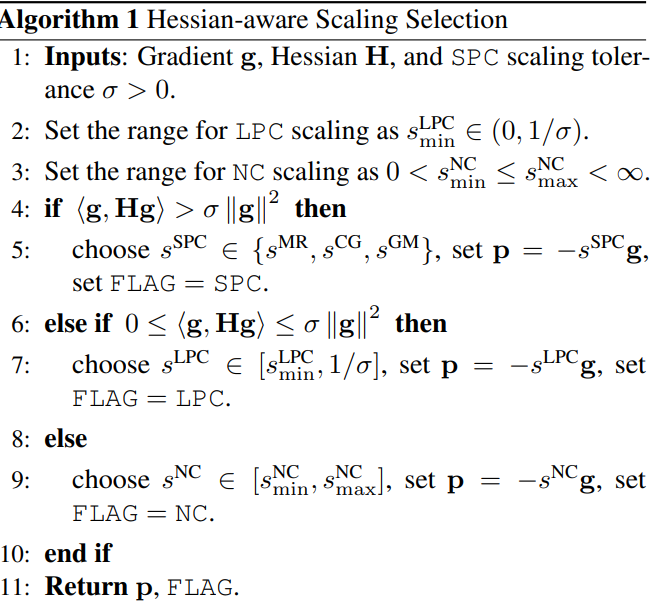

In [55]:
#algorithm 1: Hessian-aware scaling selection

def scaling_selection(g, H, sigma, constant_learning_rate=True):
    
    Hg = np.dot(H, g)
    dot_product = np.dot(g, Hg)
    norm_g = np.linalg.norm(g)

    if constant_learning_rate:
        s_lpc_min = 1 / sigma #set to 1/sigma for constant learning rate
        s_lpc_max = 1 / sigma #set to 1/sigma for constant learning rate
    else:
        s_lpc_min = 1 / sigma * np.random.random()

    s_CG = np.linalg.norm(g)**2 / dot_product
    s_MR = dot_product / np.linalg.norm(Hg)**2
    s_GM = np.sqrt(s_CG * s_MR)

    if dot_product > sigma * norm_g**2:
        spc = np.random.choice([s_CG, s_MR, s_GM])
        return -spc*g, "SPC"
    elif 0 < dot_product and dot_product < sigma * norm_g**2:
        slpc = np.random.uniform(s_lpc_min, 1 / sigma)
        return -slpc * g, "LPC"
    else:
        snc = np.random.uniform(s_lpc_min, s_lpc_max)
        return -snc * g, "NC"

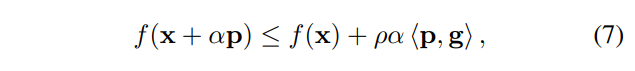

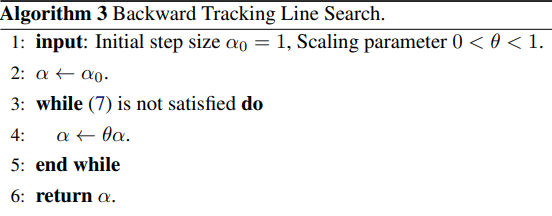

In [56]:
#algorithm 3 backward tracking line search

def backtracking_LS(model, theta, rho, x, g, p):

    alpha = 1.0
    while model(x + alpha * p) > model(x) + alpha * rho * np.dot(g, p):
        alpha *= theta


    return alpha


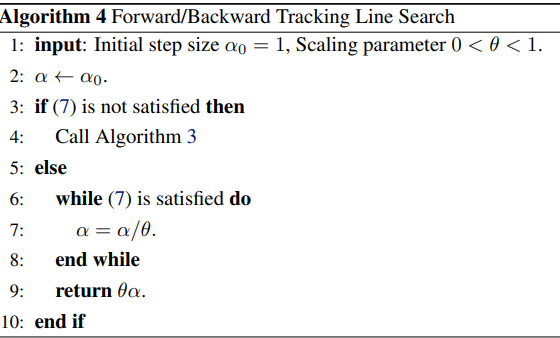

In [57]:
# algorithm 4 forward/backward tracking line search

def forward_backward_LS(model, theta, rho, x, g, p):
    alpha = 1.0
    if model(x + alpha * p) > model(x) + alpha * rho * np.dot(g, p):
        backtracking_LS(model, theta, rho, x, g, p)
    else:
        while model(x + alpha * p) >= model(x) + alpha * rho * np.dot(g, p):
            alpha /= theta

    return alpha * theta

    

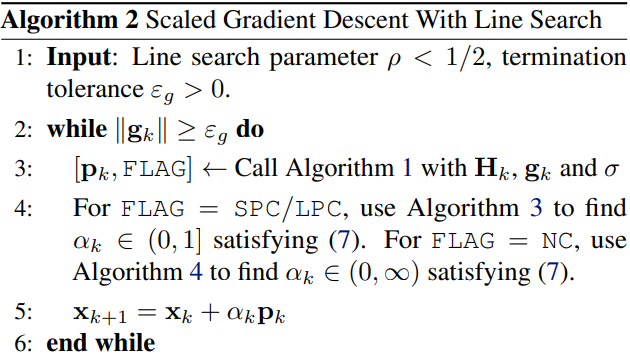

In [58]:
# algorithm 2: scaled gradient descent with line search


def scaled_GD(model, x0, sigma, rho, theta_bt, theta_fb, MAX_ITER, eps):
    """
    sigma <<< 1
    0 < theta < 1
    0 < rho < 1/2
    """

    x_k = x0
    flag_distribution = {"SPC": 0, "LPC": 0, "NC": 0}


    for _ in range(MAX_ITER):

        g_k = 2 * x_k

        if np.linalg.norm(g_k) < eps:
            break
        

        p_k, FLAG = scaling_selection(g_k, np.eye(len(x_k)), sigma)
        flag_distribution[FLAG] += 1

        if FLAG == "SPC" or FLAG == "LPC":
            alpha_k = backtracking_LS(model, theta_bt, rho, x_k, g_k, p_k)

        else:
            alpha_k = forward_backward_LS(model, theta_fb, rho, x_k, g_k, p_k)

        x_k += alpha_k * p_k

    return x_k, flag_distribution

        

In [ ]:
#try with ||x||² for now
model = lambda x: np.linalg.norm(x)**2

sigma = 0.1
theta_bt = 0.5
theta_fb = 0.5
rho = 0.25

MAX_ITER = 1000
eps = 1e-12

x_0 = 10 * np.random.randn(10)


x_star, flag_distribution = scaled_GD(model, x_0, sigma, rho, theta_bt, theta_fb, MAX_ITER, eps)

In [60]:
x_star

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [62]:
flag_distribution

{'SPC': 1, 'LPC': 0, 'NC': 0}